In [12]:
import matplotlib
import scipy.io
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
from sklearn.linear_model import LinearRegression

In [13]:
# Known data
G = 0.14 # Nms
I = 0.15 # kgm^2
tau = 60 # ms
# geometry
l_forearm = 33 # cm - wrist-elbow
l_arm = 30 # cm - elbow-shoulder
# targets
r = 18 # cm
t = 0.6 # s - time reaching movement


In [14]:
# x[k+1] = A*x[k] + B*u[k]

# choose data for the state
theta = np.pi / 4# degrees (pi/4)
vel = r/t # cm/s
theta_dot = vel/l_forearm # rad/s
T = 0.5 # Ncm - random value
print("linear velocity : ", vel)
print("angular velocity : ", theta_dot)

# state vector x 
x = np.array((theta, theta_dot, T)).reshape(3,1)
print("state vector : ","\n", x)

# inputs u
u = 1
u = np.heaviside(u,1)
print("input : ", u)

linear velocity :  30.0
angular velocity :  0.9090909090909091
state vector :  
 [[0.78539816]
 [0.90909091]
 [0.5       ]]
input :  1.0


In [15]:
A = np.array([0,1,0,0,(-G/I),1/I,0,0,(-1/tau)]).reshape((3,3))
print("A matrix : ","\n",A)

A matrix :  
 [[ 0.          1.          0.        ]
 [ 0.         -0.93333333  6.66666667]
 [ 0.          0.         -0.01666667]]


In [16]:
B = np.array([0,0,(1/tau)]).reshape((3,1))
print("B matrix : ","\n", B)

B matrix :  
 [[0.        ]
 [0.        ]
 [0.01666667]]


In [17]:
# model implementation for single joint case and single reaching movement
# x[k+1] = A*x[k] + B*u[k]

y = np.matmul(A,x) + B*u
print("angular velocity : ", y[0], " corresponds to the initial computed value")
print("angular acceleration : ", y[1])
print("torque derivative : ", y[2])

angular velocity :  [0.90909091]  corresponds to the initial computed value
angular acceleration :  [2.48484848]
torque derivative :  [0.00833333]


targets  [(18.0, 0.0), (12.727922061357857, 12.727922061357857), (1.102182119232618e-15, 18.0), (-12.727922061357855, 12.727922061357857), (-18.0, 2.204364238465236e-15), (-12.727922061357859, -12.727922061357855), (-3.3065463576978533e-15, -18.0), (12.727922061357852, -12.727922061357859), (18.0, -4.408728476930472e-15)]


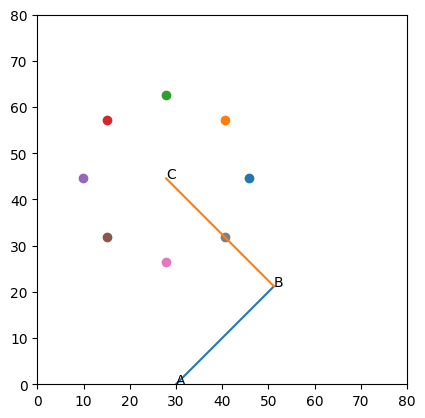

In [18]:
# plot starting position
theta_shoulder = 0
theta_elbow = 0
A = [30,0]
theta_shoulder = np.pi/4 # rad
theta_elbow = np.pi*3/4 #  rad
# compute joint positions 
B = [0,0]
B[0] = A[0] + np.cos(theta_shoulder)*l_arm
B[1] = A[1] + np.sin(theta_shoulder)*l_arm
C = [0,0]
C[0] = B[0] + np.cos(theta_elbow)*l_forearm
C[1] = B[1] + np.sin(theta_elbow)*l_forearm
#print(C)
#print('theta_shoulder (rad) ', theta_shoulder)
#print('theta_shoulder (deg) ', np.rad2deg(theta_shoulder))

# targets
points = [(np.cos(2*np.pi/8*x)*18,np.sin(2*np.pi/8*x)*18) for x in range(0,8+1)]
print('targets ', points)

# figure 
fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')
centre = (C[0],C[1])
#ax.add_patch(Circle(centre,18,fill=False))
for i in range(0,8):
    plt.scatter(C[0]+points[i][0],C[1]+points[i][1])
plt.xlim(0,80)
plt.ylim(0,80)
plt.plot([A[0],B[0]],[A[1],B[1]])
plt.plot([B[0],C[0]],[B[1],C[1]])
labels = ['A','B','C']
plt.text(A[0],A[1],'A')
plt.text(B[0],B[1],'B')
plt.text(C[0],C[1],'C')

plt.show()

target:  [45.87867965644036, 44.5477272147525]
AC:  47.293048829948084
BC:  33.0


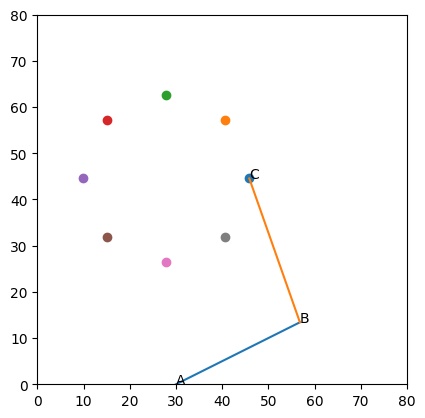

target:  [40.60660171779822, 57.27564927611036]
AC:  58.2494635168428
BC:  33.00000000000002


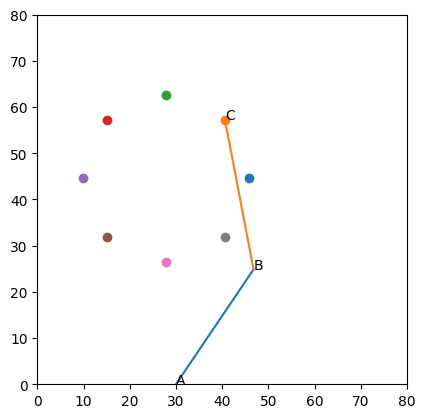

target:  [27.87867965644036, 62.5477272147525]
AC:  62.58368940651462
BC:  33.0


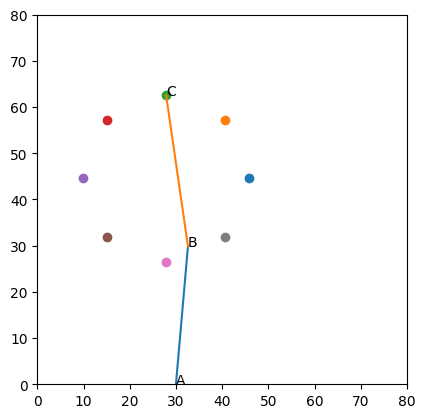

target:  [15.150757595082506, 57.27564927611036]
AC:  59.16924876994807
BC:  32.99999999999999


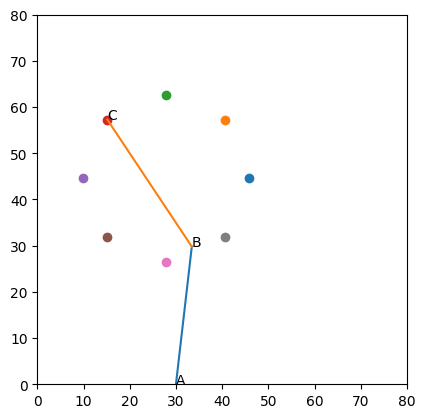

target:  [9.878679656440362, 44.5477272147525]
AC:  48.88115723229297
BC:  33.00000000000001


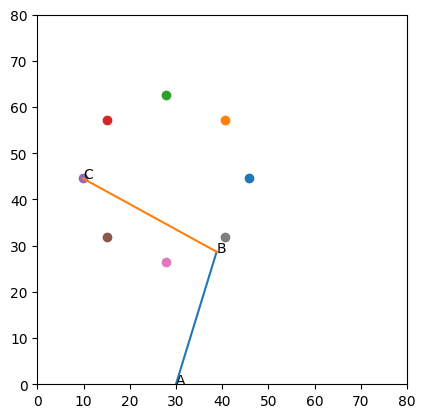

target:  [15.150757595082503, 31.819805153394643]
AC:  35.11409973215888
BC:  33.00000000000001


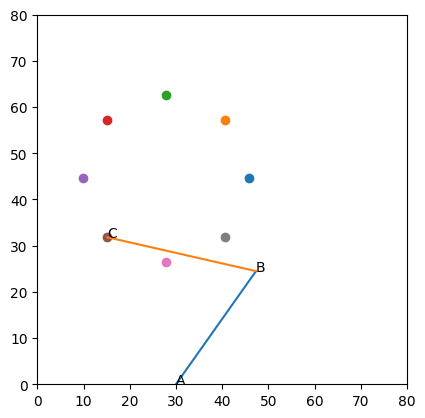

target:  [27.878679656440358, 26.5477272147525]
AC:  26.632345376795307
BC:  33.0


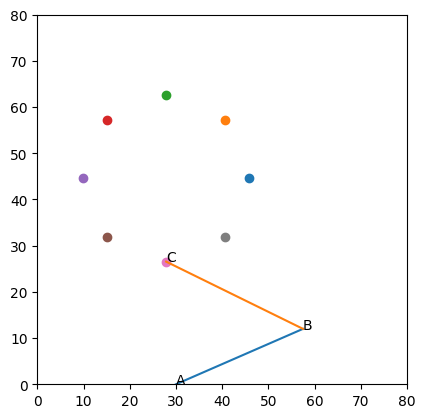

target:  [40.60660171779821, 31.81980515339464]
AC:  33.54101966249685
BC:  33.0


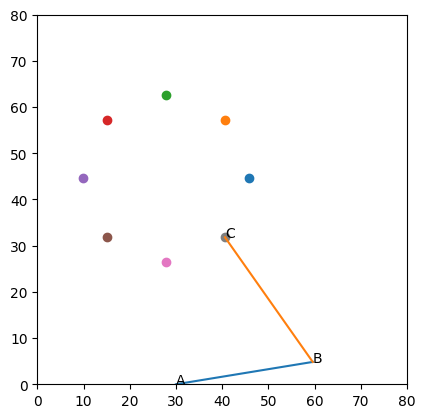

target:  [45.87867965644036, 44.54772721475249]
AC:  47.29304882994807
BC:  33.0


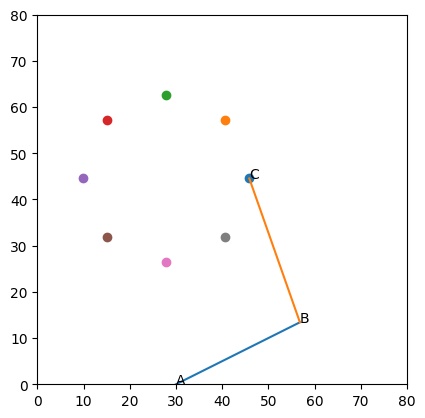

In [19]:
# change position over time
# constants
A = [30,0]

# figure
fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')

for point in points :
    target = [C[0]+point[0], C[1]+point[1]]
    print('target: ',target)
    # distance A-target
    A_target = np.sqrt((target[0]-A[0])**2+(target[1]-A[1])**2)
    print('AC: ',A_target)
    
    # angle between AC and x-axis
    beta = np.arccos((A[0]-target[0])/A_target)
    # angle between AC and AB
    alpha = np.arccos((A_target**2+l_arm**2-l_forearm**2)/(2*A_target*l_arm))
    
    theta_shoulder = np.pi-beta-alpha

    # compute joint positions
    A = [30,0]
    B = [0,0]
    B[0] = A[0] + np.cos(theta_shoulder)*l_arm
    B[1] = A[1] + np.sin(theta_shoulder)*l_arm
    BC = np.sqrt((target[0]-B[0])**2+(target[1]-B[1])**2)
    print('BC: ',BC)
    
    # figure 
    plt.cla()
    plt.gca().set_aspect('equal', adjustable='box')
    centre = (C[0],C[1])
    #ax.add_patch(Circle(centre,18,fill=False))
    for i in range(0,8):
        plt.scatter(C[0]+points[i][0],C[1]+points[i][1])
    plt.xlim(0,80)
    plt.ylim(0,80)
    plt.plot([A[0],B[0]],[A[1],B[1]])
    plt.plot([B[0],target[0]],[B[1],target[1]])
    labels = ['A','B','C']
    plt.text(A[0],A[1],'A')
    plt.text(B[0],B[1],'B')
    plt.text(target[0],target[1],'C')
    
    plt.show()


Q matrix :  
 [[ 5  0  0 -5  0  0]
 [ 0  1  0  0 -1  0]
 [ 0  0  2  0  0 -2]
 [-5  0  0  5  0  0]
 [ 0 -1  0  0  1  0]
 [ 0  0 -2  0  0  2]]
A matrix :  
 [[1.         0.01       0.         0.         0.         0.        ]
 [0.         0.99066667 1.06666667 0.         0.         0.        ]
 [0.         0.         0.99983333 0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]]


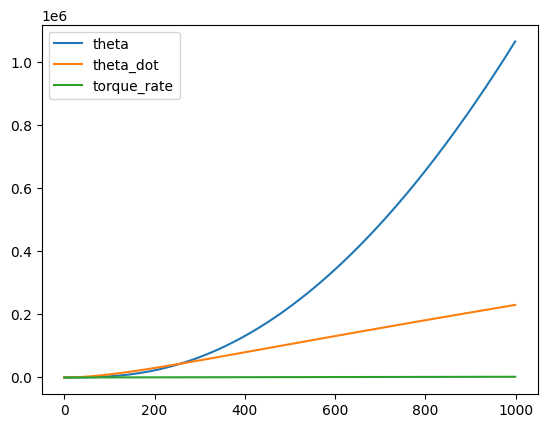

In [83]:
import time
import numpy as np

# One Joint Recursion Coding
theta = np.pi / 4
vel = r/t
theta_dot = 0
T = 0.5


dt = 0.01

Qk = np.zeros((6,6))
R = 1
# weight matrix for one joint
Q = np.array([5,0,0,-5,0,0,0,1,0,0,-1,0,0,0,2,0,0,-2,-5,0,0,5,0,0,0,-1,0,0,1,0,0,0,-2,0,0,2]).reshape((6,6))
print("Q matrix : ","\n",Q)
# since the target is static
A = np.array([1,dt,0,0,0,0,0,1 - (dt * G/I),1 + dt/I,0,0,0,0,0,1 - dt/tau,0,0,0,
              0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1]).reshape((6,6))
B = np.array([0,0,(dt/tau),1,0,0]).reshape(6,1)
print("A matrix : ","\n",A)
# amount of matrices = amount of time steps
N = 1000
S = np.zeros((6,6,N))
S[:,:, N - 1] = Q
L = np.zeros((1,6,N))  # Changed L to a 2D array

# backward pass
for k in range(0, N - 1, -1):
    temp_1 = np.linalg.inv(R + np.matmul(np.matmul(B.T, S[:,:,k + 1]), B))
    temp_2 = np.matmul(np.matmul(B.T, S[:,:,k + 1]), A)
    L[:,:,k] = temp_1 * temp_2
    S[:,:,k] = Qk + np.matmul(np.matmul(A.T, S[:,:,k + 1]), A) - np.matmul(np.matmul(A.T, S[:,:,k + 1]), B) * L[:,:,k]

# forward pass
# are the "A" and "B" matrices correctly built?
approx_theta = np.pi / 2
x = np.zeros((6,1,N))
x[:,:,0] = np.array([theta,theta_dot, T, np.pi/2, 0, 0.5]).reshape((6,1))
timesteps = N
# noise variable
# time seed
np.random.seed(5)
w = np.random.normal(0, 1, (6,1))
theta_values = []
theta_dot_values = []
torque_rate_values = []
time_values = []

for i in range(0, timesteps - 1):
    x[:,:,i+1] = (A - B @ L[:,:,i]) @ x[:,:,i] + w
    

x_axis = np.arange(0, timesteps)
plt.plot(x_axis, x[0,0,:], label='theta')
plt.plot(x_axis, x[1,0,:], label='theta_dot')
plt.plot(x_axis, x[2,0,:], label='torque_rate')
plt.legend()
plt.show()
